In [1]:
import os

import numpy as np

import torch
import torchvision
from torchvision.io import read_image
from torchvision.transforms import v2

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from piq import BRISQUELoss, TVLoss, brisque, ssim, psnr

import random

import cv2

import matplotlib.pyplot as plt

from utils import loss_history, plot_history

from tqdm import tqdm

import json

import wandb

import kornia

from torch_trainer import torch_trainer
import data
import loss

%matplotlib inline

In [2]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
class ChannelAttention(nn.Module):
    def __init__(self,channel,reduction=16):
        super().__init__()
        self.maxpool=nn.AdaptiveMaxPool2d(1)
        self.avgpool=nn.AdaptiveAvgPool2d(1)
        self.se=nn.Sequential(
            nn.Conv2d(channel,channel//reduction,1,bias=False),
            ##nn.ReLU(),
            nn.GELU(),
            nn.Conv2d(channel//reduction,channel,1,bias=False)
        )
        self.sigmoid=nn.Sigmoid()
    
    def forward(self, x) :
        max_result=self.maxpool(x)
        avg_result=self.avgpool(x)
        max_out=self.se(max_result)
        avg_out=self.se(avg_result)
        output=self.sigmoid(max_out+avg_out)
        return output

class SpatialAttention(nn.Module):
    def __init__(self,kernel_size=7):
        super().__init__()
        self.conv=nn.Conv2d(2,1,kernel_size=kernel_size,padding=kernel_size//2)
        self.sigmoid=nn.Sigmoid()
    
    def forward(self, x) :
        max_result,_=torch.max(x,dim=1,keepdim=True)
        avg_result=torch.mean(x,dim=1,keepdim=True)
        result=torch.cat([max_result,avg_result],1)
        output=self.conv(result)
        output=self.sigmoid(output)
        return output



class CBAMBlock(nn.Module):

    def __init__(self, channel=512,reduction=16,kernel_size=49):
        super().__init__()
        self.ca=ChannelAttention(channel=channel,reduction=reduction)
        self.sa=SpatialAttention(kernel_size=kernel_size)


    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        b, c, _, _ = x.size()
        residual=x
        out=x*self.ca(x)
        out=out*self.sa(out)
        return out+residual

In [4]:
class conv_block(nn.Module):
    def __init__(self, activation=nn.GELU(), *args, **kwargs):
        super(conv_block, self).__init__()
        self.conv1 = nn.Conv2d(*args, **kwargs)
        #self.bn = nn.BatchNorm2d(kwargs['out_channels'])
        self.activation1 = activation
        self.conv2 = nn.Conv2d(*args, **kwargs)
        self.cbam = CBAMBlock(channel=kwargs['out_channels'])
        
    def forward(self, x):
        x_input = x
        x = self.conv1(x_input)
        #x = self.bn(x)
        x = self.activation1(x)
        x = self.conv2(x)
        x = self.cbam(x) + x_input
        return x
    
class sr_from_lr(nn.Module):
    def __init__(self, scale=2, n_blocks=8, channels=64, activation=nn.GELU(), activation_out=nn.Sigmoid()):
        super().__init__()
        
        self.n_blocks = n_blocks
        self.channels = channels
        self.scale = scale
        self.activation = activation
        self.activation_out = activation_out
               
        self.upscale = nn.Upsample(scale_factor=scale, mode='bicubic')
        
        self.conv_in = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=channels, kernel_size=3, padding='same'),
            #activation,
            #nn.Conv2d(in_channels=channels//6, out_channels=channels//4, kernel_size=3, padding='same'),
            #activation,
            #nn.Conv2d(in_channels=channels//4, out_channels=channels//2, kernel_size=3, padding='same'),
            #activation,
            #nn.Conv2d(in_channels=channels//2, out_channels=channels, kernel_size=3, padding='same'),
            #activation
            
        )
        
        self.conv_inner_blocks = nn.ModuleList(conv_block(activation=activation,
                                     in_channels=channels,
                                     out_channels=channels,
                                     kernel_size=3,
                                     padding='same') for n in range(n_blocks))
                
        self.conv_out = nn.Sequential(
            #nn.Conv2d(in_channels=channels, out_channels=channels//2, kernel_size=3, padding='same'),
            #activation,
            #nn.Conv2d(in_channels=channels//2, out_channels=channels//4, kernel_size=3, padding='same'),
            #activation,
            #nn.Conv2d(in_channels=channels//4, out_channels=channels//6, kernel_size=3, padding='same'),
            #activation,
            nn.Conv2d(in_channels=channels, out_channels=3, kernel_size=3, padding='same'),
        )
        
    
    def forward(self, x):
        x = self.upscale(x)
        x = self.conv_in(x)        
        for conv_inner in self.conv_inner_blocks:
            x = conv_inner(x)
        x = self.conv_out(x)
        if self.activation_out:
            x = self.activation_out(x)
        return x
           

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print (device) 

cuda


# patches

In [6]:
ds_realsr_lr_patches = data.data_patches_realsr_x2_train(patch_size=(256,256))
ds_train_patches, ds_val_patches = torch.utils.data.random_split(ds_realsr_lr_patches, [0.8, 0.2])

100%|████████████████████████████████████████████████████████████████████████████████| 406/406 [01:09<00:00,  5.83it/s]


In [7]:
BATCH_SIZE = 2

dl_train_patches = DataLoader(ds_train_patches, batch_size=BATCH_SIZE, shuffle=True)
dl_val_patches = DataLoader(ds_val_patches, batch_size=1, shuffle=False)
dl_lr_patches = {'train': dl_train_patches, 'test': dl_val_patches}

In [8]:
scale = 2

def rescale(img, img_true):
    _, _, h, w = img_true.shape
    tr = torchvision.transforms.Compose([
        #torchvision.transforms.GaussianBlur((5,5), sigma=0.5),
        torchvision.transforms.Resize(size=(h, w), antialias=True, interpolation=torchvision.transforms.InterpolationMode.BICUBIC)
                                        ])
    return tr(img)

def loss_ssim_l2(y_pred, y_true, eps=1e-5):
    #y_pred_down = rescale(y_pred, y_true)
    y_pred_down = kornia.geometry.pyrdown(y_pred)
    #loss_ssim = kornia.losses.ssim_loss(y_pred_down, y_true, window_size=11, max_val=1.)
    loss_l2 = nn.MSELoss()(y_pred_down, y_true)
    #loss_brisque = BRISQUELoss(data_range=1)(y_pred)
    #loss_canny = kornia.filters.canny(y_pred)[0].mean()
    loss_tv = kornia.losses.total_variation(y_pred, reduction='mean').sum()
    del y_true
    del y_pred_down
    torchvision.utils.save_image(y_pred[0], './run/v3_pred.png')
    del y_pred
    eps = 1e-10
    return loss_l2 + 0.1*loss_tv #+ 1./loss_tv


def metric_ssim(y_pred, y_true):
    y_pred_down = rescale(y_pred, y_true)
    #y_pred_down = kornia.geometry.pyrdown(y_pred)
    #y_pred_down = kornia.geometry.rescale(input=y_pred, factor=(1/scale,1/scale))
    return kornia.metrics.ssim(y_pred_down, y_true, window_size=11, max_val=1.).mean()
    #return ssim(y_pred_down, y_true, data_range=1)

torch.cuda.empty_cache()
model = sr_from_lr(scale=scale, n_blocks=5, channels=128).to(device)
print(model)
criterion = loss_ssim_l2
optimizer = torch.optim.Adamax(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.5, patience=3,min_lr=1e-10)
trainer = torch_trainer(model=model,
                       criterion=criterion,
                       optimizer=optimizer,
                       scheduler=scheduler, 
                       epochs=20,
                       dataloader=dl_lr_patches)
trainer.set_metrics(metric_name='SSIM', metric_function=metric_ssim)
#trainer.wandb_log(True)

#run = wandb.init(project='itmo blind superresolution', 
#                 group='v2_realsr_zssr', 
#                 job_type='train')
#wandb.watch(model, criterion, log="all", log_freq=10)

history = trainer.train()

sr_from_lr(
  (activation): GELU(approximate='none')
  (activation_out): Sigmoid()
  (upscale): Upsample(scale_factor=2.0, mode='bicubic')
  (conv_in): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  )
  (conv_inner_blocks): ModuleList(
    (0-4): 5 x conv_block(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (activation1): GELU(approximate='none')
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (cbam): CBAMBlock(
        (ca): ChannelAttention(
          (maxpool): AdaptiveMaxPool2d(output_size=1)
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (se): Sequential(
            (0): Conv2d(128, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): GELU(approximate='none')
            (2): Conv2d(8, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
          (sigmoid): Sigmoid()
        )
        (sa): SpatialAttention(
          (

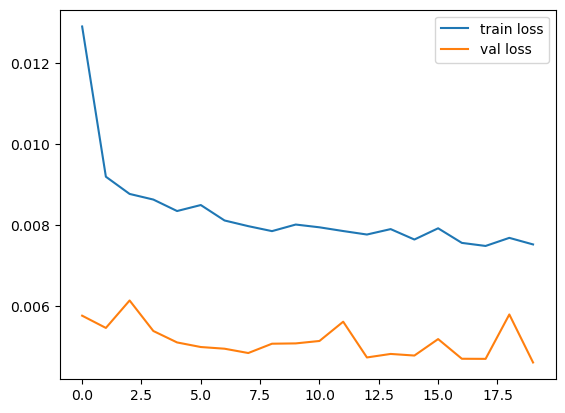

In [9]:
trainer.history.plot()

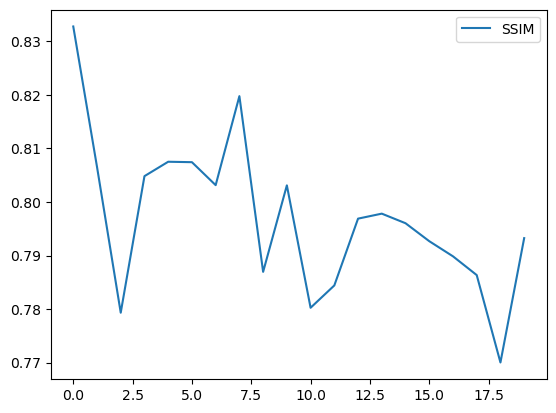

In [10]:
trainer.history.plot(train=False, val=False, metric='SSIM')

In [11]:
def plot_results(img_lr, img_reconstructed, img_gt):
    img_lr_resized = kornia.geometry.resize(img_lr, (img_reconstructed.shape[1],
                                                     img_reconstructed.shape[2]), interpolation='bicubic', antialias=True)
    ssim_lr = kornia.metrics.ssim(img1=img_lr_resized[None,:], img2=img_gt[None,:], window_size=11).mean()
    ssim_reconstructed = kornia.metrics.ssim(img_reconstructed[None,:], img_gt[None,:], window_size=11).mean()
    plt.subplots(1,3, figsize=(15,10))
    plt.subplot(1,3,1)
    plt.imshow(img_gt.permute(1,2,0))
    plt.title(f'hr ground true')
    plt.subplot(1,3,2)
    plt.imshow(img_lr_resized.permute(1,2,0))
    plt.title(f'bicubic, SSIM={ssim_lr:.4f}')
    plt.subplot(1,3,3)
    plt.imshow(img_reconstructed.permute(1,2,0))
    plt.title(f'reconstructed, SSIM={ssim_reconstructed:.4f}')

In [12]:
torch.save(model.state_dict(), 'cnn_256_11blocks_128_20ep_l2_01tv_pyrdown.pt')

In [19]:
#model = sr_from_lr(scale=2, n_blocks=8, channels=256).to(device)
#model.load_state_dict(torch.load('cnn_256.pt'))
#model.eval()
print(model)

sr_from_lr(
  (activation): GELU(approximate='none')
  (activation_out): Sigmoid()
  (upscale): Upsample(scale_factor=1.0, mode='nearest')
  (conv_in): Sequential(
    (0): Conv2d(3, 128, kernel_size=(1, 1), stride=(1, 1), padding=same)
  )
  (conv_inner_blocks): ModuleList(
    (0-10): 11 x conv_block(
      (conv1): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=same)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation1): GELU(approximate='none')
      (cbam): CBAMBlock(
        (ca): ChannelAttention(
          (maxpool): AdaptiveMaxPool2d(output_size=1)
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (se): Sequential(
            (0): Conv2d(128, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): ReLU()
            (2): Conv2d(8, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
          (sigmoid): Sigmoid()
        )
        (sa): SpatialAttention(
          (conv

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


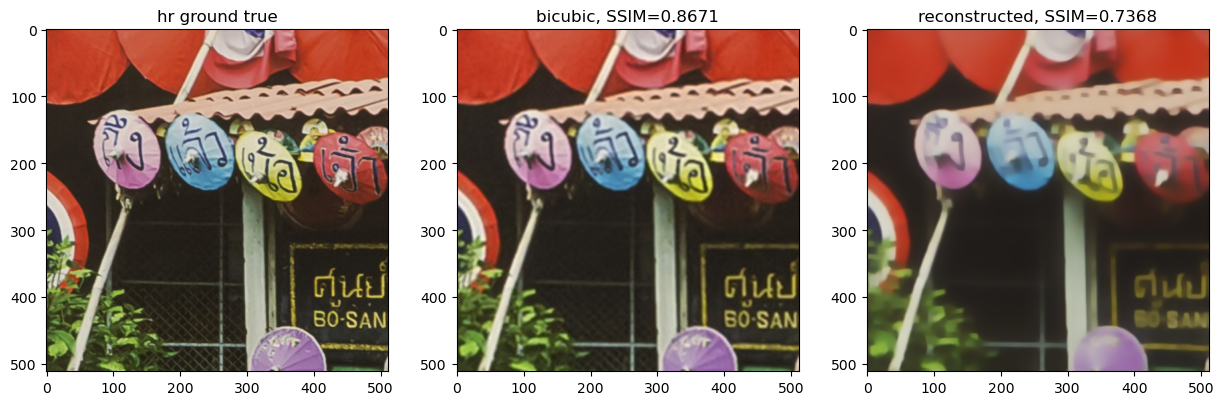

In [13]:
n = 55
torch.cuda.empty_cache()
device_ = 'cuda'
img_lr = ds_train_patches.dataset.images_source_patches[n]
img_ref = ds_train_patches.dataset.images_ref_patches[n]
model.eval()
with torch.no_grad():
    model = model.to(device_)
    img_reconstructed = model(img_lr[None,:].to(device_))[0].detach().cpu()
plot_results(img_lr, img_reconstructed, img_ref)
torchvision.utils.save_image(img_lr, 'v3_in.png')
torchvision.utils.save_image(img_reconstructed, 'v3_out.png')
torchvision.utils.save_image(img_ref, 'v3_ref.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


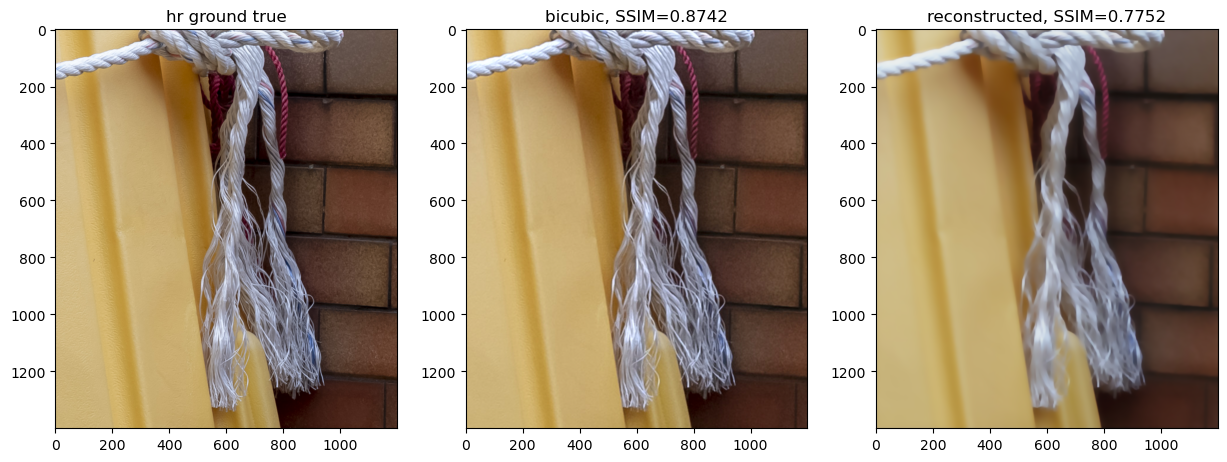

In [14]:
n = 300
torch.cuda.empty_cache()
device_ = 'cuda'
img_lr = ds_train_patches.dataset.images_source_img[n]
img_ref = ds_train_patches.dataset.images_ref_img[n]
model.eval()
with torch.no_grad():
    model = model.to(device_)
    img_reconstructed = model(img_lr[None,:].to(device_))[0].detach().cpu()
plot_results(img_lr, img_reconstructed, img_ref)
torchvision.utils.save_image(img_lr, 'v3_full_in.png')
torchvision.utils.save_image(img_reconstructed, 'v3_full_out.png')
torchvision.utils.save_image(img_ref, 'v3_full_ref.png')

In [15]:
ds_set5 = data.data_set5_x2()
ds_urban100 = data.data_urban100_x2()

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.02it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


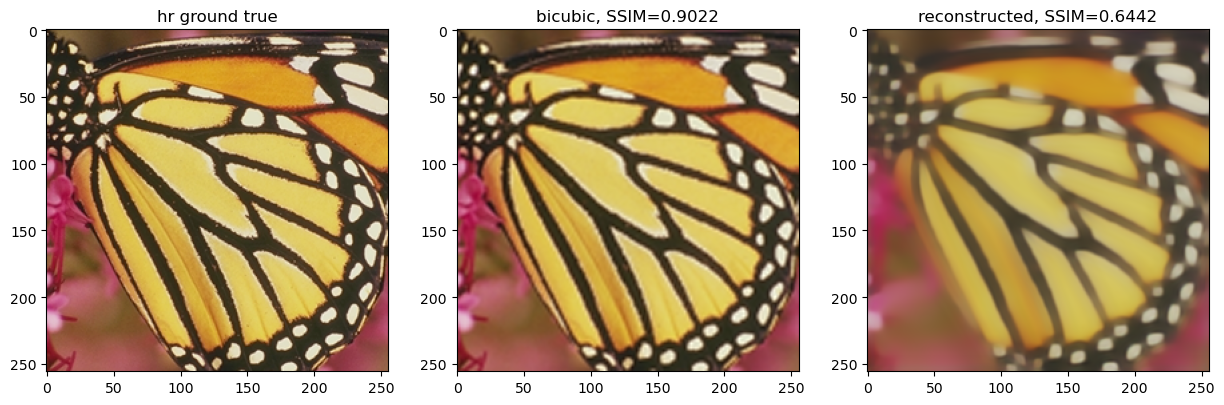

In [16]:
n = 2
torch.cuda.empty_cache()
device_ = 'cuda'
img_lr = ds_set5.images_source_img[n]
img_ref = ds_set5.images_ref_img[n]
model.eval()
with torch.no_grad():
    model = model.to(device_)
    img_reconstructed = model(img_lr[None,:].to(device_))[0].detach().cpu()
plot_results(img_lr, img_reconstructed, img_ref)
torchvision.utils.save_image(img_lr, 'v3_set5_in.png')
torchvision.utils.save_image(img_reconstructed, 'v3_set5_out.png')
torchvision.utils.save_image(img_ref, 'v3_set_ref.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


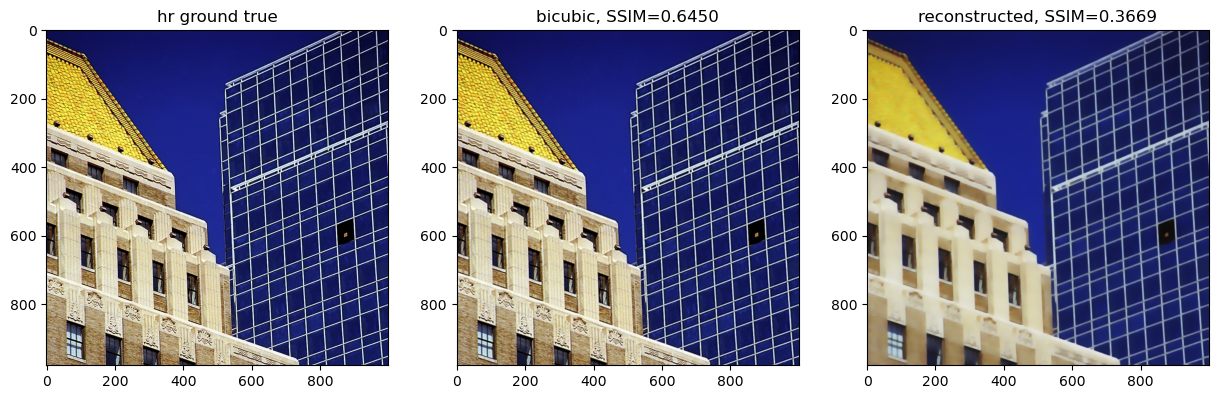

In [17]:
n = 62
torch.cuda.empty_cache()
device_ = 'cuda'
img_lr = ds_urban100.images_source_img[n]
img_ref = ds_urban100.images_ref_img[n]
model.eval()
with torch.no_grad():
    model = model.to(device_)
    img_reconstructed = model(img_lr[None,:].to(device_))[0].detach().cpu()
plot_results(img_lr, img_reconstructed, img_ref)
torchvision.utils.save_image(img_lr, 'v3_urban100_in.png')
torchvision.utils.save_image(img_reconstructed, 'v3_urban100_out.png')
torchvision.utils.save_image(img_ref, 'v3_urban100_ref.png')